In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os


In [2]:
# Directory path containing the ROOT files
directory_path = '/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal'

# Define the specific files you want to include (with subdirectories)
desired_files = [
    'emu/emu_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'emu/emu_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'emu/emu_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root'
]

# Construct the full paths for the desired files
file_paths = [os.path.join(directory_path, filename) for filename in desired_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees = [uproot.open(file_path)['ttBar_treeVariables_step8'] for file_path in file_paths]

# Concatenate the TTrees from all files into a single TTree
file = uproot.concatenate(trees)

In [38]:
file['eventWeight']

<Array [0.76, 0.684, 0.793, ..., 0.519, 0.749, 0.589] type='1001618 * float32'>

In [4]:
mg_weight=file['mgWeights']
mg_weight

<Array [[1.14, 1.1, ..., 0.799, 0.799], ...] type='1001618 * var * float32'>

In [91]:
#Obtain the structure constant
import Event_weight_prediction
SC1= Event_weight_prediction.obtain_structure_constant(16, mg_weight)

In [92]:
import Data_store
Data_store.save_structure_constants(SC1, save_file='/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco')

Structure constants saved to /depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco


In [5]:
# Directory path containing the ROOT files
dir_data = '/eos/purdue/store/user/lingqian/minitrees2016preVFP/spinCorrInput_2016preVFP_November2024/Nominal/'

# Define the specific files you want to include (with subdirectories)
all_files = [
    'emu/emu_run2016B.root',
    'emu/emu_run2016C.root',
    'emu/emu_run2016D.root',
    'emu/emu_run2016E.root',
    'emu/emu_run2016F1.root'
    
]

# Construct the full paths for the desired files
paths = [os.path.join(dir_data, filename) for filename in all_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees_data = [uproot.open(file_path)['ttBar_treeVariables_step8'] for file_path in paths]

# Concatenate the TTrees from all files into a single TTree
file_data = uproot.concatenate(trees_data)

In [6]:
file_data

<Array [{top_pt: 86.9, top_phi: ..., ...}, ...] type='66409 * {top_pt: floa...'>

In [7]:
file_data['eventWeight']

<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1] type='66409 * float32'>

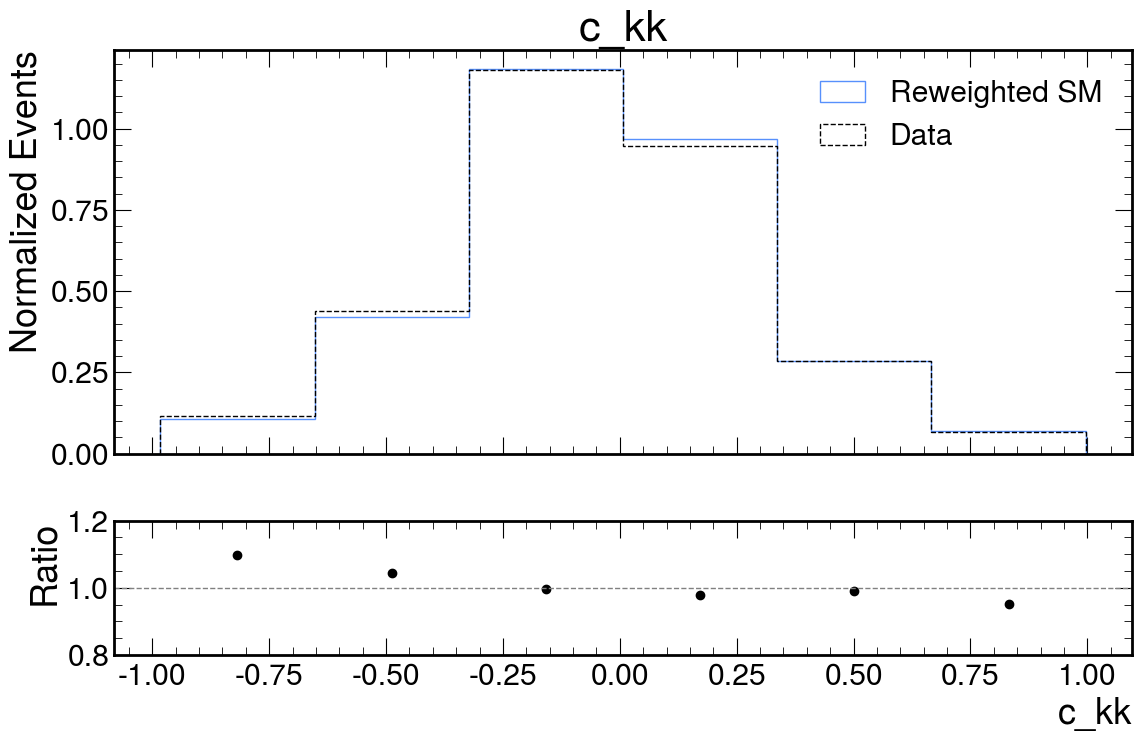

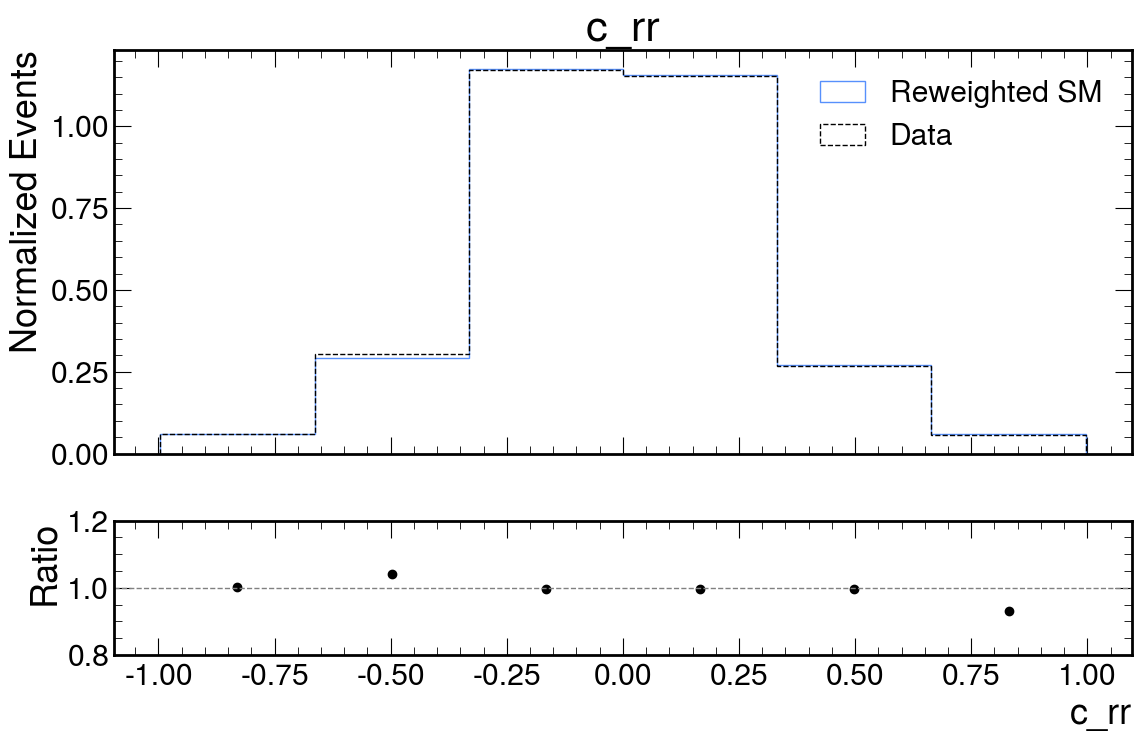

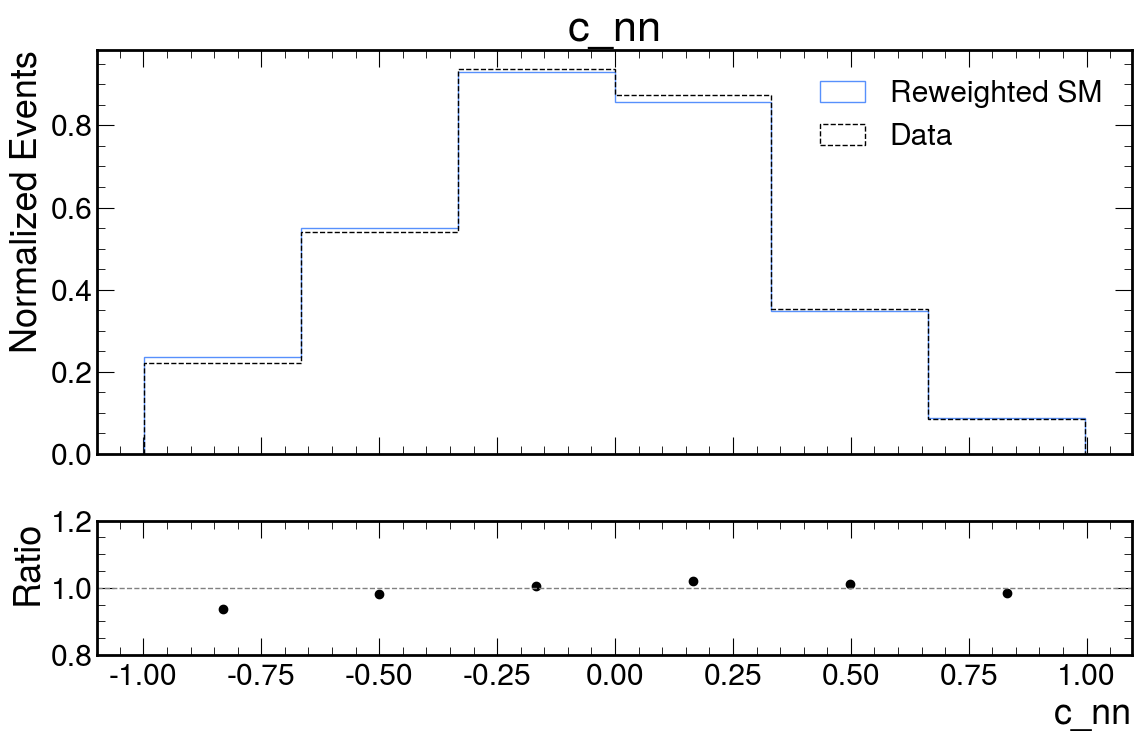

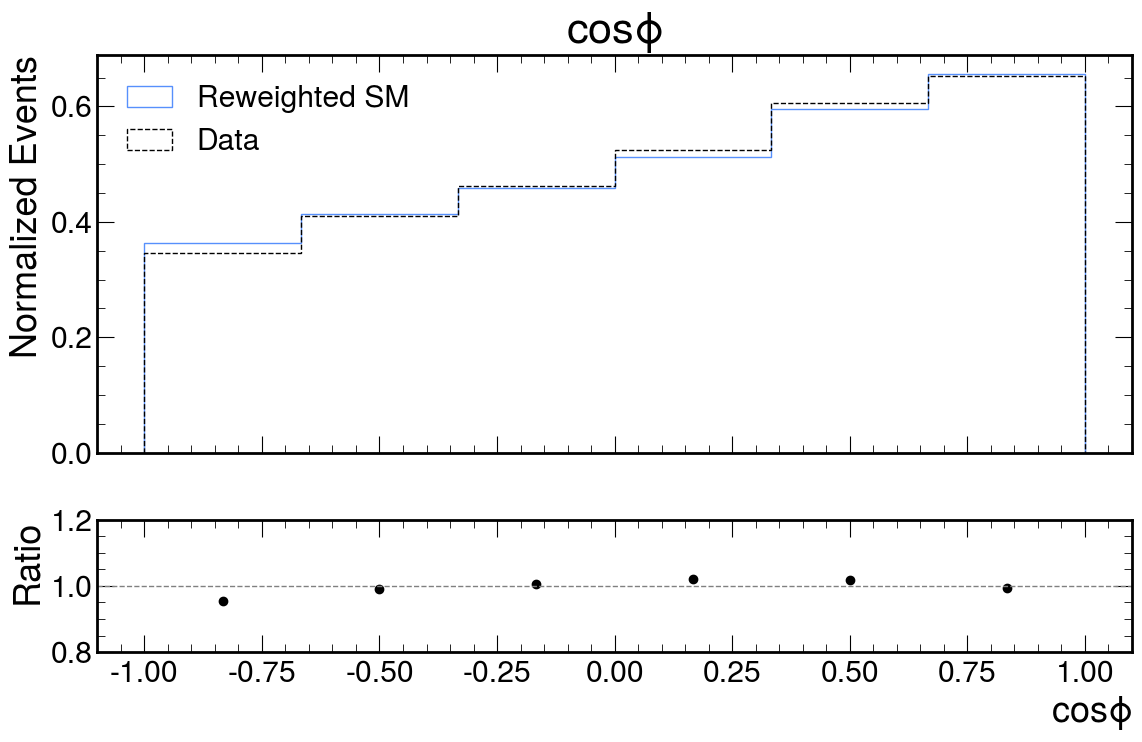

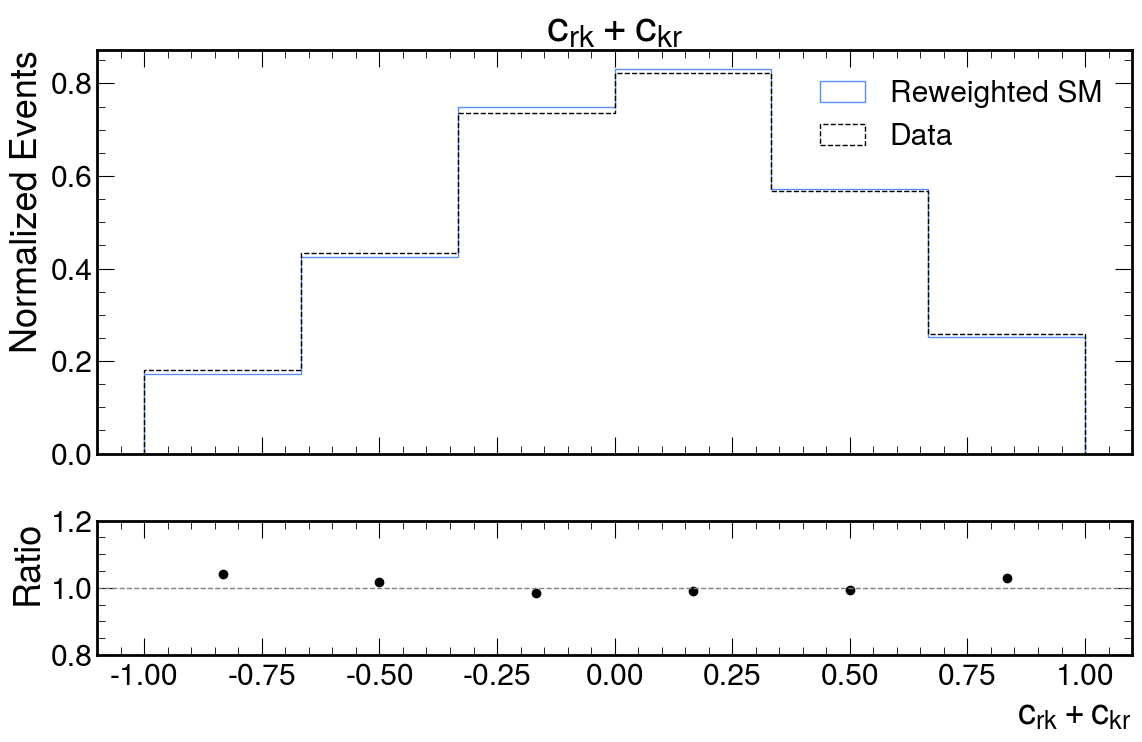

In [39]:
import plotting__script2
mask_file = (file['l_pt'] >= 1 ) & (file['lbar_pt'] >= 1)
observables_reco = {
    
    'c_kk': file['c_kk'][mask_file],
    'c_rr': file['c_rr'][mask_file],
    'c_nn': file['c_nn'][mask_file],
    'll_cHel': file['ll_cHel'][mask_file],
    'crk_ckr': file['c_rk'][mask_file] + file['c_kr'][mask_file],
}

observables_data_reco = {
    'c_kk': file_data['c_kk'],
    'c_rr': file_data['c_rr'],
    'c_nn': file_data['c_nn'],
    'll_cHel': file_data['ll_cHel'],
    'crk_ckr': file_data['c_rk'] + file_data['c_kr'],
}

# List of observables to plot
observables_to_plot_reco = {
    'c_kk': ('c_kk', 'c_kk'),
    'c_rr': ('c_rr', 'c_rr'),
    'c_nn': ('c_nn', 'c_nn'),
    'll_cHel': ('$cos\phi$', '$cos\phi$'),
    'crk_ckr': ('$c_{rk}+c_{kr}$', '$c_{rk}+c_{kr}$'),
}

total_weight=mg_weight[:,200]*file['eventWeight']
#plot_observables_ReweightedSM_SM(obs, obs_sm_file, xlabel, title, weights_dict, num_bins=50)
weights_dict = {
    'reweighted_SM':total_weight  # SM weights from existing data
}
reweight_sample={}
sm_sample={}
# Loop through and plot all observables
for obs_key, (xlabel, title) in observables_to_plot_reco.items():
    reweighted, sm_data=plotting__script2.plot_observables_ReweightedSM_SM(observables_reco[obs_key], observables_data_reco[obs_key], xlabel, title, weights_dict,num_bins=6)
    reweight_sample[obs_key]=reweighted
    sm_sample[obs_key]=sm_data


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
import Event_weight_prediction
import mplhep as hep
from uncertainties import unumpy as unp
plt.style.use(hep.style.CMS)

SC_saved = np.load('/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco.npy', allow_pickle=True)
mask_file = (file['l_pt'] > 0) & (file['lbar_pt'] > 0)

def assymetry(cosArr, weight, weight_sm):
    """Compute asymmetry A for a given observable array, using final weights."""
    weights=weight*weight_sm
    N1 = ufloat(np.sum(weights[cosArr > 0]), np.sqrt(np.sum(weights[cosArr > 0]**2)))
    N2 = ufloat(np.sum(weights[cosArr < 0]), np.sqrt(np.sum(weights[cosArr < 0]**2)))
    
    return (N1 - N2) / (N1 + N2)
    
def compute_deviations(wc_name, wc_range, observables, weights, weight_sm, SC_saved):
    """Generalized function to compute deviations for any Wilson Coefficient."""
    constant_factor_Cij = -4.0  
    constant_factor_CijCji = -16 / np.pi  
    constant_factor_D = -2
    deviations_dict = {}
    parameter_value = {}
    parameter_sm_value = {}
    Deviation_error={}
    for obs_name, obs_data in observables.items():
        deviations = []
        deviations_error = []
        
        # Assign appropriate constant factor
        if obs_name == "D":  # Check if the observable is cosphi (for D)
            constant_factor = constant_factor_D
        elif "+" in obs_name:
            constant_factor = constant_factor_CijCji
        else:
            constant_factor = constant_factor_Cij

        # Compute reference coefficient at weight_sm
        A_sm = assymetry(obs_data, weights, weight_sm)
        param_value_sm = constant_factor * A_sm
        parameter_sm_value[obs_name] = param_value_sm

        for wc_value in wc_range:
            wc_vector = [0] * 16  # Assume a 16-dimensional WC space
            wc_vector[0] = wc_value  # Modify only the relevant WC
            
            weight_wc, _, _ = Event_weight_prediction.event_weights_lin_quad(SC_saved, wc_vector)
            A_wc = assymetry(obs_data, weights, weight_wc[mask_file])
            param_value_wc = constant_factor * A_wc
            #parameters.append(param_value_wc)
            
            # Compute deviation from SM (keeps both central value and uncertainty)
            deviation = -(param_value_wc- param_value_sm)  # This remains a `ufloat` object
            
            # Extract nominal value (central value) and standard deviation (error)
            deviations.append(deviation.nominal_value)
            deviations_error.append(deviation.std_dev)

            
        deviations_dict[obs_name] = deviations
        Deviation_error[obs_name]= deviations_error

    return  deviations_dict, Deviation_error

# Define the range of Wilson Coefficient values
wc_name =['ctGRe', 'ctGIm', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']   
wc_values = np.linspace(-0.5, 0.5, 21)

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['c_kk'][mask_file],
    r'$C_{nn}$': file['c_nn'][mask_file],
    r'$C_{rr}$': file['c_rr'][mask_file],
    r'D' : file['ll_cHel'][mask_file],
    r'$C_{rk}+C_{kr}$': file['c_rk'][mask_file] + file['c_kr'][mask_file],
}

weight_sm=mg_weight[:,200][mask_file]
weights=file['eventWeight'][mask_file]

# Compute deviations
deviations, Deviation_error= compute_deviations(wc_name[0], wc_values, observables, weights, weight_sm, SC_saved)



In [53]:
# Save to a NumPy file
np.savez("/depot/cms/top/bhanda25/EFT_minitree/Deviation_from_sm/deviations_data_includeD_error_ctGRe_Reco.npz", deviations=deviations, deviation_error=Deviation_error)



In [54]:
#Load the file
data = np.load("/depot/cms/top/bhanda25/EFT_minitree/Deviation_from_sm/deviations_data_includeD_error_ctGRe_Reco.npz", allow_pickle=True)
deviations=data["deviations"].item()
deviations_error=data["deviation_error"].item()

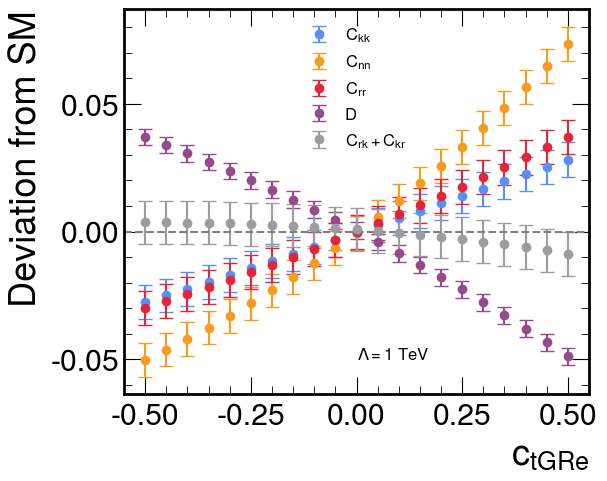

In [56]:
# Plot results

fig, ax = plt.subplots(figsize=(6,5))

for obs_name, dev_values in deviations.items():
    ax.errorbar(wc_values, dev_values, yerr=deviations_error[obs_name], marker='o', linestyle='none', label=obs_name, capsize=5)  # Removed line connection

ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel(r'$c_{tGRe}$')
ax.set_ylabel('Deviation from SM')
ax.legend(fontsize=12)
plt.text(0, -0.05, r'$\Lambda = 1\ \rm{TeV}$', fontsize=12)

plt.show()


In [20]:
#Chi square minimization process 
mask_file1 = (file['l_pt'] > 0) & (file['lbar_pt'] > 0)
wc_names =['ctGRe', 'ctGIm', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']   
observables = [ 'll_cHel']  # List of observables

data = {obs: file_data[obs] for obs in observables}
eft = {obs: file[obs] for obs in observables}



In [21]:
data

{'ll_cHel': <Array [-0.354, 0.0806, -0.329, ..., 0.909, -0.754] type='66409 * float32'>}

In [22]:
eft

{'ll_cHel': <Array [0.971, -0.307, 0.474, ..., -0.72, 0.617] type='1001618 * float32'>}

In [30]:
import Event_weight_prediction
import numpy as np
import Computed_statistics_chi_square4
import Reco_statistics_24
import Chi_square_test_stat3


# Path to structure constants
path_to_SC = '/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco.npy'

#event weights at reco
eft_reco_weights=file['eventWeight']

# Define Wilson coefficient indices to scan
wc_indices = [0, 1]#, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15]  # Extend this list for other WCs if needed

# Define binning and list of observables
bins = 6
x_label = r"$cos \phi$"#$\Delta \phi_{ll}$']#,'$cos\phi$']  # Example observable

# Loop over WC indices and compute histograms
histograms = {}

for wc_index in wc_indices:
    # Compute event weights for the given wc_index
    event_weights, weight_sm = Computed_statistics_chi_square4.compute_event_weights_ctgRe(
        file, mask_file1, path_to_SC, wc_index=wc_index, ctgRe_min=-1, ctgRe_max=1, num_points=11
    )

    # Compute histograms for the given WC
    #hist_obs_list, hist_obs_err_list, eft_events, eft_errors, bin_edges = Chi_square_test_stat3.compute_values_for_chi_square(
    #    eft,  # Pass list of observables
    #    weight_sm,
    #    event_weights,
    #    bins
    #)
     # Compute histograms for the given WC

    hist_obs_list, hist_obs_err_list, eft_events, eft_errors, bin_edges = Reco_statistics_24.compute_values_for_chi_square(
        data,
        eft,  # Pass list of observables
        event_weights,
        eft_reco_weights,
        bins
    )
    # Store results for this WC
    histograms[wc_index] = {
        "hist_obs_list": hist_obs_list,
        "hist_obs_err_list": hist_obs_err_list,
        "eft_events": eft_events,
        "eft_errors": eft_errors,
        "bin_edges": bin_edges
    }

# Now `histograms` contains results for each wc_index


In [31]:
histograms

{0: {'hist_obs_list': [array([0.34617905, 0.4101474 , 0.46160218, 0.5239894 , 0.60607309,
          0.65206164])],
  'hist_obs_err_list': [array([0.00395459, 0.00430448, 0.00456652, 0.00486533, 0.00523255,
          0.00542744])],
  'eft_events': {-1.0: [array([0.33749791, 0.39755235, 0.45255023, 0.51576804, 0.61169521,
           0.68498901])],
   -0.8: [array([0.34129877, 0.39993944, 0.45347926, 0.51530084, 0.60932869,
           0.68070575])],
   -0.6: [array([0.34563834, 0.40270146, 0.45456775, 0.51476736, 0.60660697,
           0.67577087])],
   -0.3999999999999999: [array([0.35057156, 0.40588028, 0.45583473, 0.51416082, 0.60349187,
           0.67011349])],
   -0.19999999999999996: [array([0.35615177, 0.40951765, 0.45729951, 0.51347465, 0.59994572,
           0.66366345])],
   0.0: [array([0.36242724, 0.41365289, 0.45898073, 0.5127029 , 0.59593359,
           0.6563554 ])],
   0.20000000000000018: [array([0.36943657, 0.41831975, 0.46089503, 0.51184082, 0.59142631,
           0.64

Plotting for ctGRe (wc_index: 0)


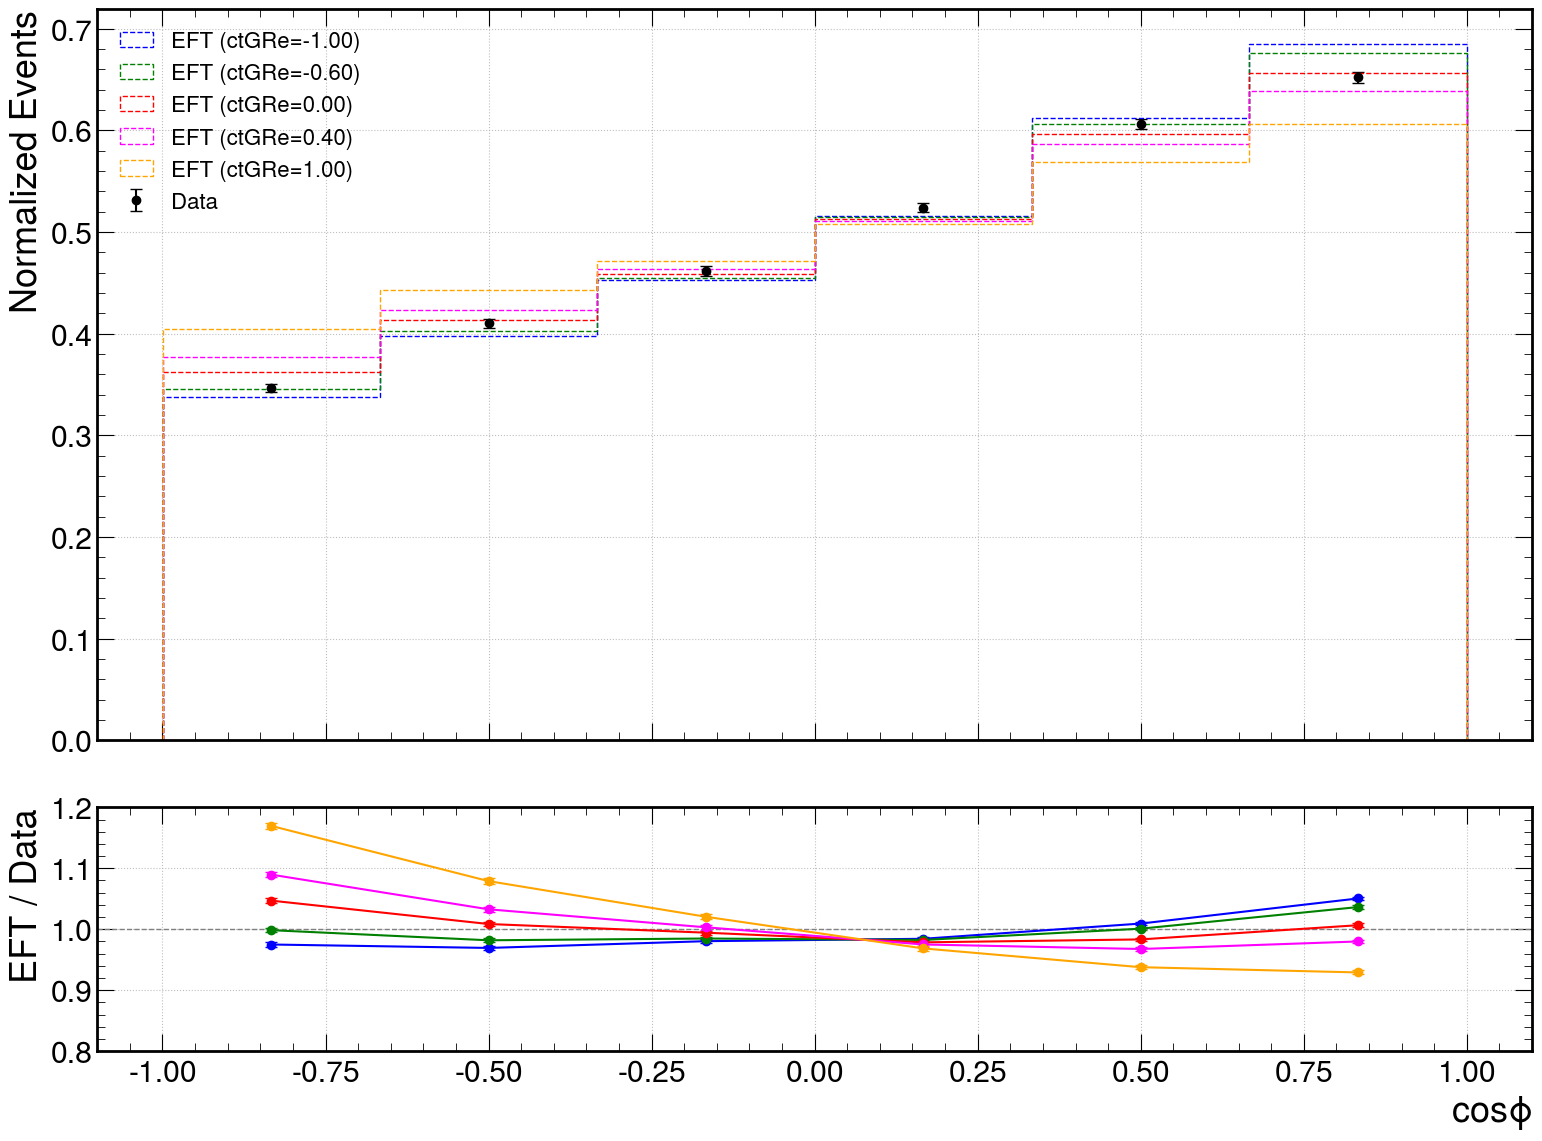

Plotting for ctGIm (wc_index: 1)


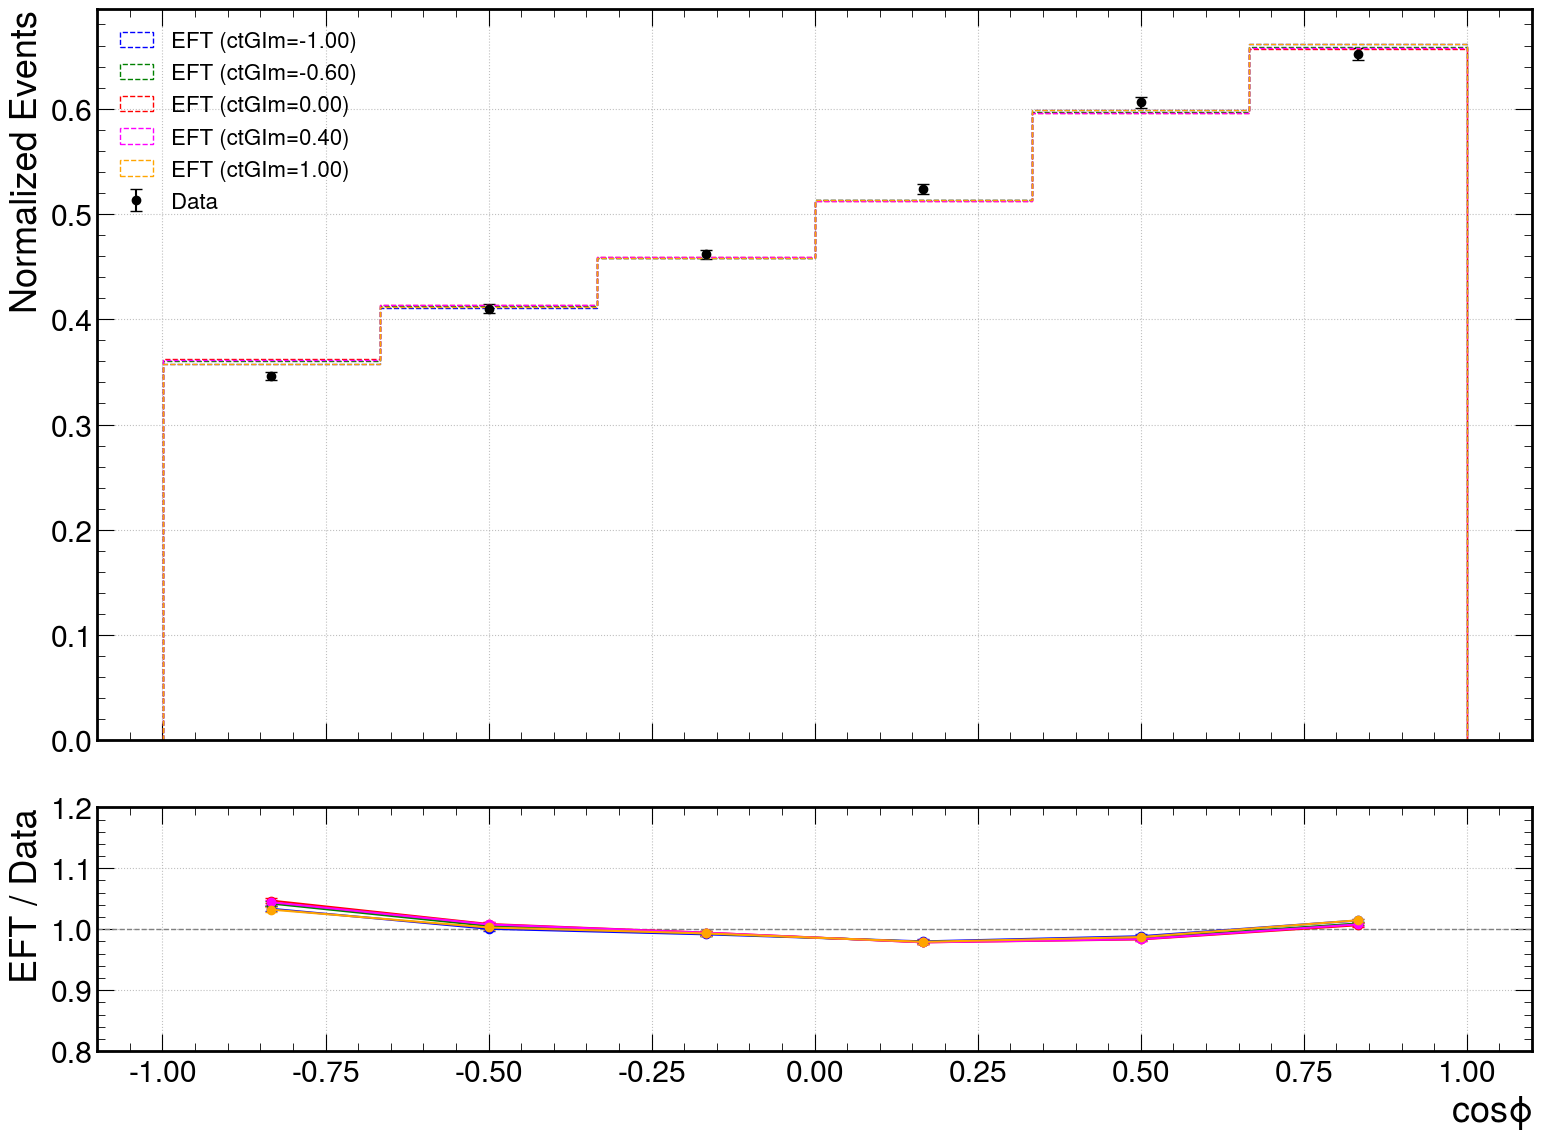

In [25]:
import Plot_SM_vs_EFT_29

# Dictionary to map wc_index to labels
wc_labels = {0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1', 
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'}


# Loop over computed histograms for each WC index
for wc_index, hist_data in histograms.items():
    wc_name = wc_labels.get(wc_index, f"wc_{wc_index}")  # Get name, default to wc_index if unknown
    print(f"Plotting for {wc_name} (wc_index: {wc_index})")  

    # Extract stored histograms for this WC index
    hist_obs_list = hist_data["hist_obs_list"]
    hist_obs_err_list = hist_data["hist_obs_err_list"]
    eft_events = hist_data["eft_events"]
    eft_errors = hist_data["eft_errors"]
    bin_edges = hist_data["bin_edges"]

    # Plot the histograms
    Plot_SM_vs_EFT_29.plot_sm_vs_eft_histograms(
        observables,
        bin_edges,
        hist_obs_list, 
        hist_obs_err_list, 
        eft_events, 
        eft_errors,
        x_label,
        wc_name=wc_name,
        legend_sizes=16
    )


In [34]:
import Reco_statistics_24

# Dictionary to map wc_index to labels
wc_labels = {0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1', 
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'}

# Dictionary to store chi-square statistics
chi_square_stat = {}
errors={}
# Loop over computed histograms for each WC index
for wc_index, hist_data in histograms.items():
    # Get the WC name (e.g., "ctGRe" or "ctGIm")
    wc_name = wc_labels.get(wc_index, f"wc_{wc_index}")  # Default to wc_index if unknown  

    # Extract stored histograms for this WC index
    hist_obs_list = hist_data["hist_obs_list"]
    hist_obs_err_list = hist_data["hist_obs_err_list"]
    eft_events = hist_data["eft_events"]
    eft_errors = hist_data["eft_errors"]
    bin_edges = hist_data["bin_edges"]
    # Initialize a dictionary for storing chi-square values for this WC name
    chi_square_stat[wc_name] = {}
    errors[wc_name]={}
    # Loop through the eft_events for each variation (like ctGRe values)
    for ctgRe_value, hist_eft_list in eft_events.items():
        hist_eft_err_list = eft_errors[ctgRe_value]
        
        # Compute Chi-square for this EFT variation (ctGRe value)
        chi_square_value, total_errors = Reco_statistics_24.compute_chi_square(
            hist_obs_list, hist_obs_err_list, hist_eft_list, hist_eft_err_list
        )
        
        # Store the chi-square value for this variation
        chi_square_stat[wc_name][ctgRe_value] = chi_square_value  # No need for further averaging
        errors[wc_name][ctgRe_value]=total_errors
    

In [35]:
chi_square_stat


{'ctGRe': {-1.0: 10.634090364347987,
  -0.8: 7.59321209708664,
  -0.6: 5.07710861280931,
  -0.3999999999999999: 3.453057702646494,
  -0.19999999999999996: 3.195451371531771,
  0.0: 4.8970566333510055,
  0.20000000000000018: 9.271820668713897,
  0.40000000000000013: 17.143247134396077,
  0.6000000000000001: 29.411337358124463,
  0.8: 46.991312289500556,
  1.0: 70.71982752864278},
 'ctGIm': {-1.0: 3.3403870135409774,
  -0.8: 3.7500646789314303,
  -0.6: 4.1796529338779544,
  -0.3999999999999999: 4.552112950876954,
  -0.19999999999999996: 4.8049150471533535,
  0.0: 4.8970566333510055,
  0.20000000000000018: 4.81383280557793,
  0.40000000000000013: 4.568555727524945,
  0.6000000000000001: 4.200927658628723,
  0.8: 3.7723533941070677,
  1.0: 3.358987950730981}}

In [36]:
errors

{'ctGRe': {-1.0: [array([0.00412642, 0.00449046, 0.00476603, 0.00507873, 0.00546776,
          0.00568115])],
  -0.8: [array([0.00413975, 0.00450386, 0.00477958, 0.00509257, 0.00548227,
          0.00569616])],
  -0.6: [array([0.00415438, 0.00451842, 0.00479413, 0.00510727, 0.00549753,
          0.0057118 ])],
  -0.3999999999999999: [array([0.00417042, 0.00453419, 0.00480971, 0.00512283, 0.00551348,
          0.00572794])],
  -0.19999999999999996: [array([0.00418798, 0.00455123, 0.0048263 , 0.00513919, 0.00552999,
          0.00574442])],
  0.0: [array([0.0042071 , 0.00456955, 0.00484387, 0.00515625, 0.00554692,
          0.00576103])],
  0.20000000000000018: [array([0.00422782, 0.00458913, 0.00486233, 0.00517387, 0.00556406,
          0.00577749])],
  0.40000000000000013: [array([0.00425011, 0.00460989, 0.00488155, 0.00519185, 0.00558112,
          0.00579347])],
  0.6000000000000001: [array([0.00427383, 0.00463167, 0.00490132, 0.00520994, 0.00559779,
          0.00580857])],
  0.8: [

Plotting chi-square values for ctGRe...


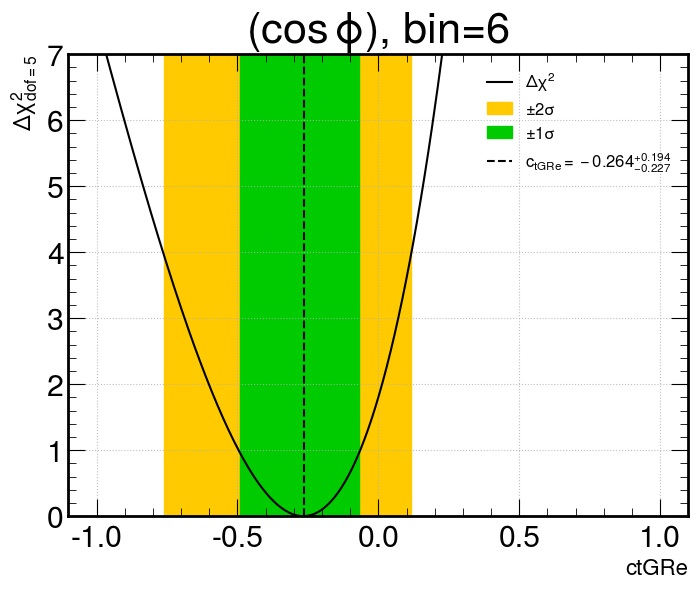

Plotting chi-square values for ctGIm...


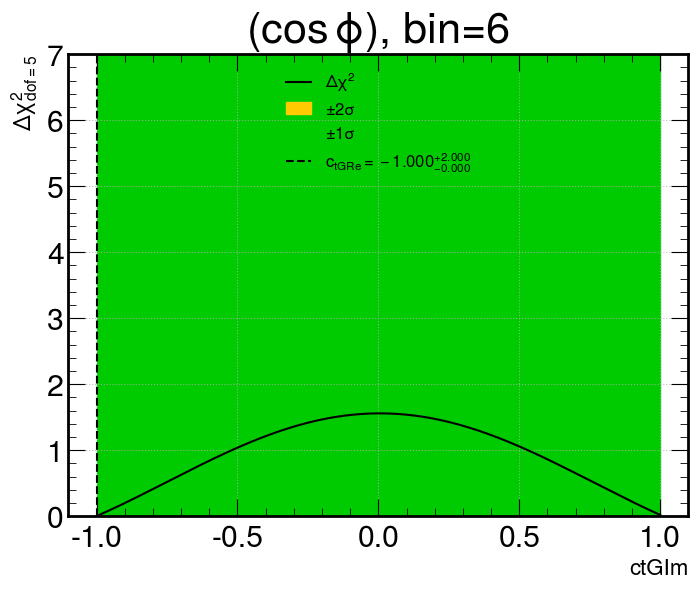

In [37]:
import Plot_limit_17

# Define the ylabel and observable variables
ylabel_chi = '$\Delta\chi^2_{dof=5}$'
variables = '$\cos \phi$'  # You can add more variables like '$\Delta \phi_{ll}$' if needed

best_list={}
sig1_list={}
sig2_list={}
# Loop over chi-square statistics for each Wilson coefficient
for wc_name, chi_square_values in chi_square_stat.items():
    print(f"Plotting chi-square values for {wc_name}...")
    
    # Plot delta chi-square for this Wilson coefficient variation
    best, up1, down1,up2,down2 = Plot_limit_17.plot_delta_chi2(
        chi_square_values, wc_name, ylabel_chi, bins, variables
    )
    best_list[wc_name]=best
    sig1_list[wc_name]=(down1, up1)
    sig2_list[wc_name]=(down2,up2)


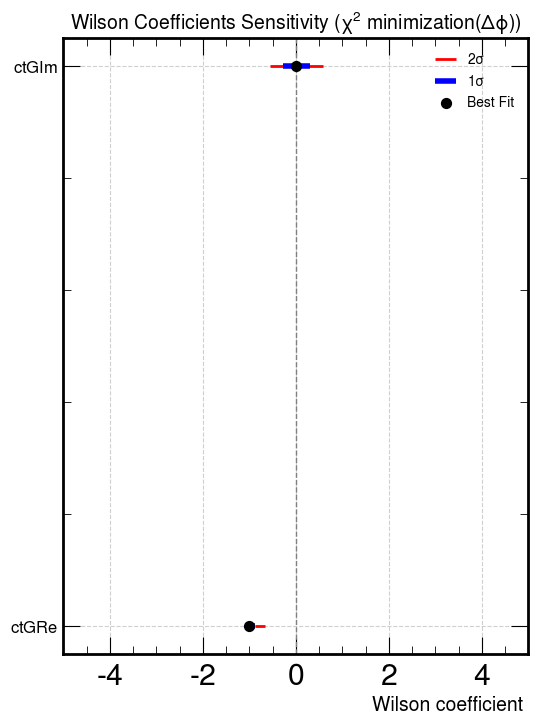

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
wilson_coeffs = list(best_list.keys())  # List of coefficient names
best_fit_values = [best_list[key] for key in wilson_coeffs]
sigma_1 = [sig1_list[key] for key in wilson_coeffs]  # Extract (lower, upper) 1σ
sigma_2 = [sig2_list[key] for key in wilson_coeffs]  # Extract (lower, upper) 2σ

# Convert to numpy arrays
y_positions = np.arange(len(wilson_coeffs))  # Vertical positioning

fig, ax = plt.subplots(figsize=(6, 8))

# Plot the 2σ confidence intervals in red
for i, (y, bf, (low2, high2)) in enumerate(zip(y_positions, best_fit_values, sigma_2)):
    ax.hlines(y, bf - low2, bf + high2, colors='red', lw=2, label=r"$2\sigma$" if i == 0 else "")

# Plot the 1σ confidence intervals in blue
for i, (y, bf, (low1, high1)) in enumerate(zip(y_positions, best_fit_values, sigma_1)):
    ax.hlines(y, bf - low1, bf + high1, colors='blue', lw=4, label=r"$1\sigma$" if i == 0 else "")

# Plot the best-fit points in black
ax.scatter(best_fit_values, y_positions, color='black', zorder=3, label="Best Fit", marker="o", s=50)

# Labels and formatting
ax.set_yticks(y_positions)
ax.set_yticklabels([f"${key}$" for key in wilson_coeffs], fontsize=12)
ax.set_xlabel(r"Wilson coefficient ", fontsize=14)
ax.axvline(0, color='gray', linestyle='dashed', lw=1)

ax.legend(loc="upper right", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(-5, 5)
plt.title(r"Wilson Coefficients Sensitivity ($\chi^2$ minimization($\Delta \phi$))", fontsize=14)

#plt.savefig("/depot/cms/top/bhanda25/EFT_minitree/Saved_plots/wilson_coefficients_sensitivity_delta_phi_4.png", dpi=300, bbox_inches='tight')
plt.show()


In [592]:
import Event_weight_prediction
import numpy as np
import Computed_statistics_chi_square4
import Reco_statistics_8
import test_statisticsPLR_7  # New module replacing Chi-square with Poisson PLR

# Path to structure constants
path_to_SC = '/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_emu_Reco.npy'

# Event weights at reco
eft_reco_weights = file['eventWeight']

# Define Wilson coefficient indices to scan
wc_indices = [0, 1]  # Extend this list for other WCs if needed

# Define binning and list of observables
bins = 6
x_label = r"$cos \phi$"  # Example observable

# Loop over WC indices and compute histograms
histograms_1 = {}
#poisson_test_statistics = {}

for wc_index in wc_indices:
    # Compute event weights for the given wc_index
    event_weights, weight_sm = Computed_statistics_chi_square4.compute_event_weights_ctgRe(
        file, mask_file1, path_to_SC, wc_index=wc_index, ctgRe_min=-5, ctgRe_max=5, num_points=11
    )

    # Compute histograms for the given WC using Poisson-based PLR statistics
    hist_obs_list, eft_events, bin_edges = test_statisticsPLR_7.compute_values_for_poisson_PLR(
        data,
        eft,  # Pass list of observables
        event_weights,
        eft_reco_weights,
        bins
    )
     # Compute Poisson PLR for each EFT variation
    #plr_stat, best_fit_c = test_statisticsPLR_6.compute_poisson_PLR(
        #hist_obs_list, counts_obs_list, eft_events, bins
    #)

    # Store results for this WC
    histograms_1[wc_index] = {
        "hist_obs_list": hist_obs_list,
        "eft_events": eft_events,
        "bin_edges": bin_edges
    }
    
    #poisson_test_statistics[wc_index] = plr_stat

# Now `histograms` contains results for each wc_index
# `poisson_test_statistics` contains the PLR test statistics for each WC


In [593]:
histograms_1

{0: {'hist_obs_list': [array([0.34617905, 0.4101474 , 0.46160218, 0.5239894 , 0.60607309,
          0.65206164])],
  'eft_events': {-5.0: [array([0.31591029, 0.38618836, 0.44893993, 0.51841737, 0.62395046,
           0.70664633])],
   -4.0: [array([0.3164883 , 0.3859564 , 0.44862934, 0.51834746, 0.62391216,
           0.70671909])],
   -3.0: [array([0.31886973, 0.38681135, 0.44872483, 0.51805597, 0.6227757 ,
           0.70481518])],
   -2.0: [array([0.32478454, 0.38991866, 0.44970921, 0.51733008, 0.61942129,
           0.69888897])],
   -1.0: [array([0.33749791, 0.39755235, 0.45255023, 0.51576804, 0.61169521,
           0.68498901])],
   0.0: [array([0.36242724, 0.41365289, 0.45898073, 0.5127029 , 0.59593359,
           0.6563554 ])],
   1.0: [array([0.40488126, 0.44252894, 0.47103846, 0.50748026, 0.56830432,
           0.60581951])],
   2.0: [array([0.45858558, 0.48091249, 0.4877006 , 0.50087008, 0.53235049,
           0.5396335 ])],
   3.0: [array([0.49658552, 0.51030438, 0.50118596

In [664]:
import test_statisticsPLR_11  # Module that contains compute_poisson_PLR function

# Dictionary to map wc_index to labels
wc_labels = {
    0: 'ctGRe', 1: 'ctGIm', 2: 'cQj18', 3: 'cQj38', 4: 'cQj11', 5: 'cQj31',
    6: 'ctu8', 7: 'ctd8', 8: 'ctj8', 9: 'cQu8', 10: 'cQd8', 11: 'ctu1',
    12: 'ctd1', 13: 'ctj1', 14: 'cQu1', 15: 'cQd1'
}

# Dictionary to store Poisson PLR statistics
poisson_plr_stat = {}

# Loop over computed histograms for each WC index
for wc_index, hist_data in histograms_1.items():
    # Get the WC name (e.g., "ctGRe" or "ctGIm")
    wc_name = wc_labels.get(wc_index, f"wc_{wc_index}")  # Default to wc_index if unknown  

    # Extract stored histograms for this WC index
    hist_obs_list = hist_data["hist_obs_list"]
    eft_events = hist_data["eft_events"]
    bin_edges = hist_data["bin_edges"]

    # Initialize a dictionary for storing Poisson PLR values for this WC name
    poisson_plr_stat[wc_name] = {}

    # Compute Poisson PLR for each EFT variation
    plr_stat, best_fit_c = test_statisticsPLR_11.compute_poisson_PLR(
        hist_obs_list, eft_events, bins
    )

    # Store the Poisson PLR value for this Wilson coefficient
    poisson_plr_stat[wc_name]= plr_stat

# Now `poisson_plr_stat` contains the Poisson PLR test statistics for each WC


In [665]:
poisson_plr_stat

{'ctGRe': {-5.0: -0.004148857958114031,
  -4.0: -0.0041226748425937385,
  -3.0: -0.0036805741487516523,
  -2.0: -0.0025387027777410047,
  -1.0: -0.000678244746119694,
  0.0: 0.0,
  1.0: -0.008387437263611498,
  2.0: -0.03702592354721087,
  3.0: -0.07139046433035125,
  4.0: -0.07871924659320162,
  5.0: -0.06397384387145755},
 'ctGIm': {-5.0: -0.005502826990119485,
  -4.0: -0.0032661277238945656,
  -3.0: -0.0012773218983641375,
  -2.0: -0.00011222654450946659,
  -1.0: 0.0,
  0.0: -0.00019580091078661615,
  1.0: -2.9183087598084665e-06,
  2.0: -0.0001015442999211275,
  3.0: -0.0012414599057481092,
  4.0: -0.003206194981351363,
  5.0: -0.005426119472760883}}

In [581]:
'ctGRe': {-5.0: 0.0016595431832456126,
  -4.0: 0.0016490699370374953,
  -3.0: 0.001472229659500661,
  -2.0: 0.001015481111096402,
  -1.0: 0.0002712978984478776,
  0.0: -0.0,
  1.0: 0.0033549749054445992,
  2.0: 0.014810369418884348,
  3.0: 0.0285561857321405,
  4.0: 0.031487698637280646,
  5.0: 0.02558953754858302},
 'ctGIm': {-5.0: 0.002201130796047794,
  -4.0: 0.0013064510895578261,
  -3.0: 0.000510928759345655,
  -2.0: 4.4890617803786637e-05,
  -1.0: -0.0,
  0.0: 7.832036431464645e-05,
  1.0: 1.1673235039233867e-06,
  2.0: 4.0617719968451e-05,
  3.0: 0.0004965839622992436,
  4.0: 0.0012824779925405452,
  5.0: 0.002170447789104353}}


289682.63514248224